# Luminosity

In [1]:
from spice.models import IcosphereModel
from spice.spectrum import simulate_spectrum, filter_responses
import astropy.units as u
from speclite import filters
import jax.numpy as jnp
from transformer_payne import TransformerPayne, Blackbody
import matplotlib.pyplot as plt

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

Let's use a simple, blackbody model just for the testing purposes, alogside with a solar-like model.

In [2]:
bb = Blackbody()
model = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., bb.solar_parameters)

To test the bolometric luminosity value, let's choose a wide range of wavelengths.

In [3]:
vws = jnp.linspace(1000., 30000., 1000)

Text(0, 0.5, 'Intensity [erg/s/cm$^3$]')

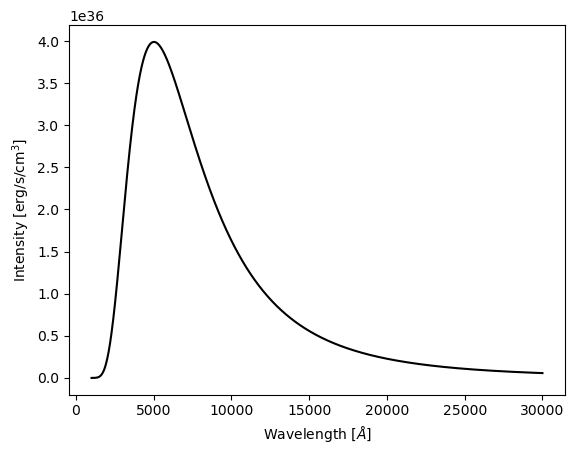

In [4]:
i_bb = simulate_spectrum(bb.intensity, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, i_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^3$]')

# Filters

Let's use the ```Filter``` subclasses to check the passband luminosities.

In [5]:
from spice.spectrum.filter import BesselB, BesselI, GaiaG

In [6]:
bessel_b = BesselB()
bessel_i = BesselI()
gaia_g = GaiaG()

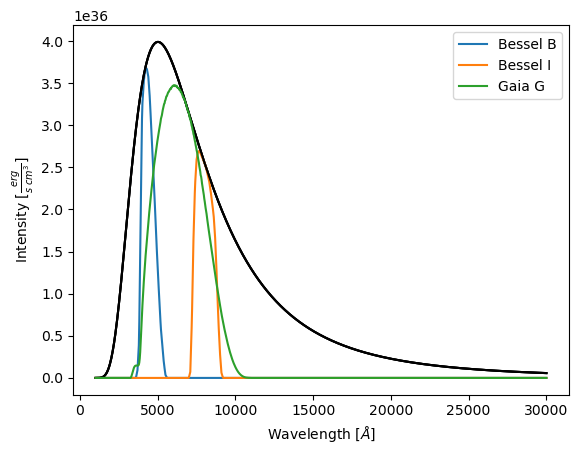

In [7]:
bessel_b.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
bessel_i.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
gaia_g.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])

The passband luminosities can be calculated using the ```AB_passband_luminosity``` function. Make sure to divide the observed luminosity by the distance first!

In [8]:
from spice.spectrum.spectrum import AB_passband_luminosity

In [9]:
solar_apparent_mag_B = AB_passband_luminosity(bessel_b, vws, i_bb[:, 0], distance=u.AU.to(u.cm))
solar_apparent_mag_I = AB_passband_luminosity(bessel_i, vws, i_bb[:, 0], distance=u.AU.to(u.cm))
solar_apparent_mag_G = AB_passband_luminosity(gaia_g, vws, i_bb[:, 0], distance=u.AU.to(u.cm))

print("Apparent magnitude of the Sun")
print("Bessel B:\t", solar_apparent_mag_B, "mag")
print("Bessel I:\t", solar_apparent_mag_I, "mag")
print("Gaia G:\t\t", solar_apparent_mag_G, "mag")

Apparent magnitude of the Sun
Bessel B:	 -26.19230118324995 mag
Bessel I:	 -27.066696902607355 mag
Gaia G:		 -26.834347838950386 mag


# Bolometric luminosity of the Sun

The bolometric luminosity of the Sun is the energy that is outputted by the whole Sun. To calculate that, we need to obtain the total flux first.

In [10]:
from spice.spectrum import luminosity, absolute_bol_luminosity

In [11]:
solar_luminosity = luminosity(bb.flux, model, jnp.log10(vws))
print("Sun's bolometric luminosity:", solar_luminosity, "erg/s")
print("Sun's absolute bolometric luminosity:", absolute_bol_luminosity(solar_luminosity), "mag")

Sun's bolometric luminosity: 3.759724164956472e+33 erg/s
Sun's absolute bolometric luminosity: 4.759510040627399 mag
